
Привет, меня зовут Люман Аблаев. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на красные комментарии ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:


<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>







<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление</font>
* Спасибо за очень качественную работу - видно, что вложено много труда.
- Я оставил некоторые советы, надеюсь они будут полезными и интересными
- Есть некоторые недочеты, которые нужно поправить, но у тебя это не должно занять много времени)
- Жду обновленную работу




<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление[2]</font>
* Спасибо за оперативность
- Приятно видеть фидбек 
- Недочеты исправлены - работа полностью корректна
- Рад был быть полезен. Удачи в дальнейшем обучении!



# Проект "Определение стоимости автомобилей" | Градиентный бустинг


Компания **«Не бит, не крашен»** разрабатывает приложение, позволяющее пользователям быстро узнать рыночную стоимость своего автомобиля. Для этого требуется построить модель, которая будет предсказывать цену на основе технических характеристик, комплектации и других параметров.

В работе проводится:

* исследование и очистка данных о машинах;
* подготовка выборок для обучения;
* обучение и сравнение нескольких моделей (градиентный бустинг и более простые алгоритмы);
* оценка качества предсказаний, времени обучения и времени работы модели на новых данных.

Цель проекта — выбрать оптимальную модель, которая сочетает **высокую точность**, **быструю обучаемость** и **оперативное предсказание**, чтобы обеспечить удобный сервис для клиентов.


## Оглавление

1) [Импорт библиотек](#0)
2) [Заведение функций](#1)
3) [Загрузка данных](#2)
4) [Предобработка данных](#3)
5) [Аналитика входных данных](#4)
6) [Заведение моделей](#5)
    1) [Линейная регрессия](#6)
    2) [LightGBM](#7)
    3) [XGBoost](#8)
    4) [CatBoost](#9)
7) [Вывод](#10)

## Импорт библиотек<a name="0"></a>

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import math
import time
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from random import randint
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [4]:
import warnings
warnings.filterwarnings("ignore")


<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>




## Заведение <a name="1"></a>

In [5]:
# Просмотр боксплотов и гистограмм для числовых признаков

def plot_num_feature(data, column, bins=30):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.boxplot(y=data[column], ax=axes[0], color="skyblue")
    axes[0].set_title(f"Boxplot: {column}")
    sns.histplot(data[column], bins=bins, ax=axes[1], kde=True, color="steelblue")
    axes[1].set_title(f"Histogram: {column}")
    plt.tight_layout()
    plt.show()


In [6]:
# Просмотр круговых диаграмм для сравнения категориальных признаков

def plot_cat_features(df, *cols):
    n = len(cols)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))

    if n == 1:
        axes = [axes]

    for i, col in enumerate(cols):
        df[col].value_counts().plot.pie(
            ax=axes[i],
            autopct="%1.0f%%",
            startangle=90
        )
        axes[i].set_title(col)
        axes[i].set_ylabel("")

    plt.tight_layout()
    plt.show()


<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошие помощники
</div>




## Загрузка данных<a name="2"></a>

Загрузим и изучим данные.

In [7]:
try:
    data = pd.read_csv('autos.csv') 
except:
    data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Предобработка данных<a name="3"></a>

Приведем названия колонок к единому виду:

In [8]:
data.columns = [
    re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower()
    for col in data.columns
]

data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Исследуем общую информацию о данных:

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

По большей части типы данных в порядке, однако есть что улучшить:
1) date_created сейчас имеет строковый типа, а лучше привести к timestamp
2) date_crawled сейчас имеет строковый типа, а лучше привести к timestamp
3) last_seen сейчас имеет строковый типа, а лучше привести к timestamp
4) repaired из строкового типа, возможно, стоит привести к булеву формату, но это потом будет сделано экнодером.

In [10]:
date_columns = ["date_crawled", "date_created", "last_seen"]

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors="coerce")

Изучим пропуски:

In [11]:
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [12]:
if data.duplicated().sum() <= 3000:
    data = data.drop_duplicates()



<div class="alert alert-block alert-info">
<b>Совет:</b> У fuel_type есть категории, которые означают одно и тоже - их можно объединить, либо подумать может они действительно означают, что-то разное.
</div>


Перед комплексной работой с пропусками, удалю неинформативные столбцы:
* date_crawled - дата объявления не относится к авто
* registration_month - месяц поставновки на учет не  так важен. Года будет достаточно
* date_created и все ниже относятся к объявлению, а не к машине
* number_of_pictures
* postal_code
* last_seen

In [13]:
data = data.drop(['date_crawled', 'registration_month', 'date_created', 
                  'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

data.sample(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
114014,6000,NaN,2018,NaN,136,NaN,150000,NaN,citroen,no
90763,200,small,1998,auto,75,other,150000,NaN,citroen,no
41230,4800,wagon,2001,manual,0,golf,80000,petrol,volkswagen,no



<div class="alert alert-block alert-success">
<b>Успех:</b> Удалить неинформативные признаки - верное решение
</div>


Пойдем по порядку в вопросе заполнения пропусков:

In [14]:
missing = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
for entry in missing:
    print(data[entry].sort_values().unique())
    print('')

['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]

['auto' 'manual' nan]

['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 'fusion' 'g

Что можно сделать с пропусками, учитывая, что удалять их не вариант, так как некоторые столбцы занимают >10% датасет:
* Не похоже, что информацию о типе топлива или модели машины мы можем сгенерировать. Наверное, лучше стоит заменить на unidentified, так как в реальности некоторые данные могут быть дейстительно неизвестны, а не потеряны только в данных. Заменю на плашку unidentified
* Тип коробки передач и данные о починке являются булевыми значениями, так что заменю на случайное значение из двух

(когда я в универе делал проект по ML, я несколько раз заполнял пропуски, обучая модель на данных без пропущенных значений и каждый раз получалось очень не очень. Перестал так делать :)

In [15]:
# 1. fuel_type и model — заменяем пропуски на 'unidentified'
data["fuel_type"] = data["fuel_type"].fillna("unidentified")
data["model"] = data["model"].fillna("unidentified")
data["vehicle_type"] = data["vehicle_type"].fillna("unidentified")

# 2. gearbox и repaired — заменяем пропуски на случайное значение из имеющихся категорий
for col in ["gearbox", "repaired"]:
    unique_vals = data[col].dropna().unique()
    n_missing = data[col].isna().sum()
    if n_missing > 0:
        data.loc[data[col].isna(), col] = np.random.choice(unique_vals, size=n_missing)

data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64


<div class="alert alert-block alert-success">
<b>Успех:</b>  Пропуски обработаны хорошим образом
</div>


Теперь проверим данные на адекватность и неявное дублицирование

In [16]:
for entry in data.columns:
    print(entry)
    print(data[entry].sort_values().unique())

price
[    0     1     2 ... 19998 19999 20000]
vehicle_type
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'unidentified'
 'wagon']
registration_year
[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]
gearbox
['auto' 'manual']
power
[    0     1     2     3     4     5  

Неявного дублицирования я не обнаружил, однако, есть странности в данных:

1) Саммая старая зарегестрированная машина - 1000 года выпуска, а самая "новая" - из будущего, из 9999 года
2) Цены на авто начинаются с 0. Слишком хорошо, чтобы быть правдой :)

В общем, данные довольно низкого качества, поэтому оставим только те, которые выглядят наиболее правдоподобными, чтобы не прогадать. Так, Ford Model T был выпущен в 1908 году как первый серийный автомобиль, так что озьму этот когд как нижнюю планку, а как верхнюю - текущий 2025-й.

Удалю данные с нулевой ценой. Все же у нас сервис по **продаже** автомобилей и о договорах дарения речи не шло

In [17]:
data = data[data['price'] != 0]
data = data[(data['registration_year'] >= 1908) & (data['registration_year'] <= 2025)]


<div class="alert alert-block alert-success">
<b>Успех:</b>  А около-нулевые цены, не кажется подозрительными? Самое интересное, что на нескольких сайтов по продажам подержанных автомобилей в Германии (страну можно определить по почтовым индексам, большинство из них из Германии) показало, что цены начинаются действительно с 0 и 1 евро, но это единичные объявления и не понятно, то ли это ошибка при заполнении формы, то ли машины на металлолом. Но я  все-таки склоняюсь к тому, чтобы избавиться от таких данных
</div>



<div class="alert alert-block alert-info">
<b>Совет:</b> Советую посмотреть на дату выгрузки анкет - там тоже можно увидеть полезную информацию по поводу границ года регистраци.
</div>


## Аналитика входных данных<a name="4"></a>

Теперь мне хотелось бы оценить распределение данных в оставшемся датасете. Это поможет с дальнейшим анализом:

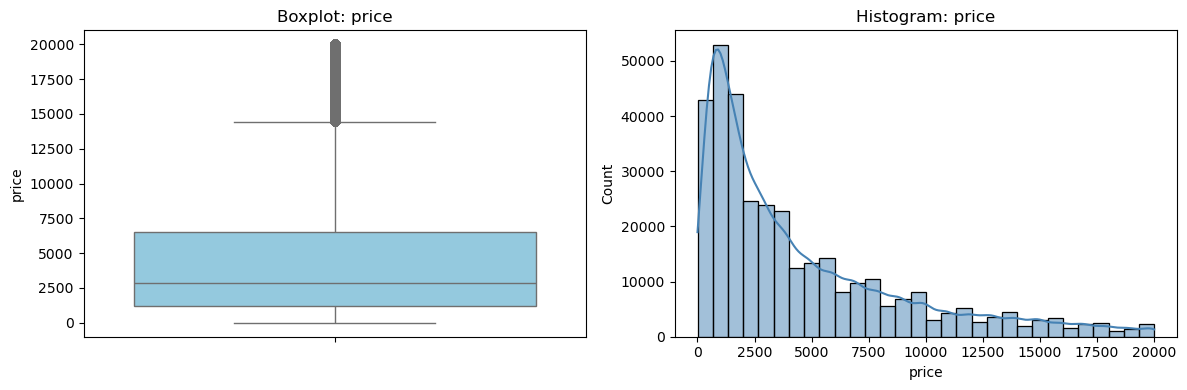

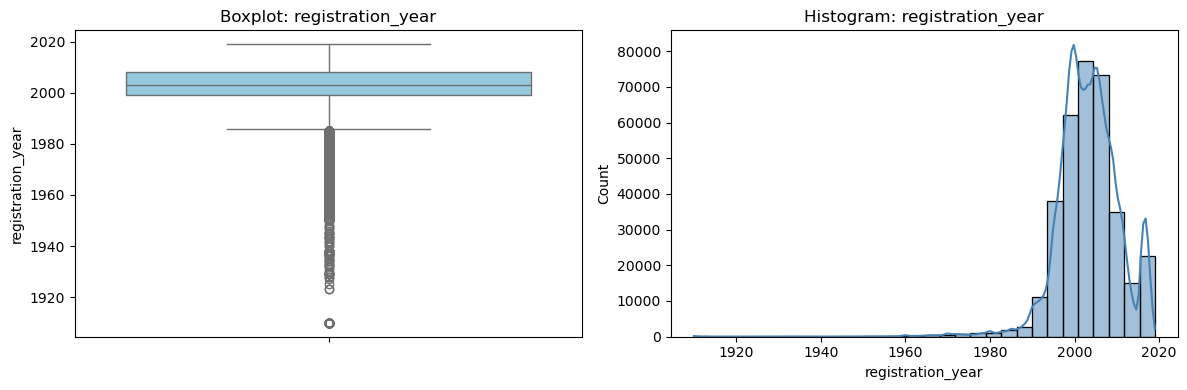

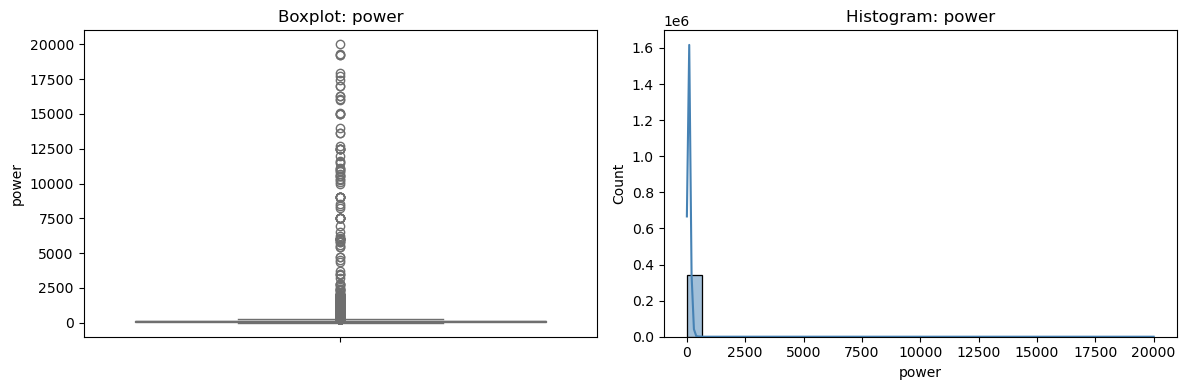

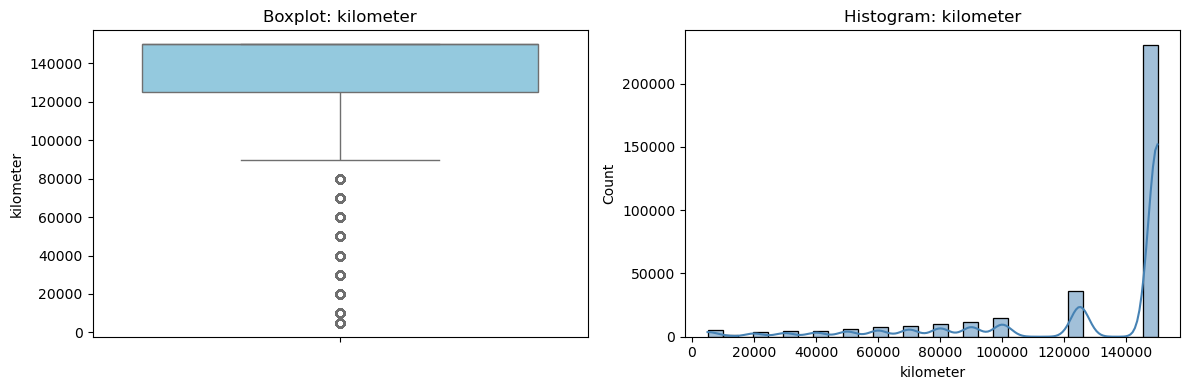

In [18]:
nums = ['price', 'registration_year', 'power', 'kilometer']
for entry in nums:
    plot_num_feature(data, entry)

**Подвывод:**

1) В большинстве своем продаются машины по цене ДО 5000
2) Основной пул продаваемых машин - авто из 200-2010 годов. Классика рынка, в общем
3) Мощность авто более 1000 - уже очень сильный выброс; с этим стоит что-то сделать
4) По километражу продаваемых автомобилей можно точно сказать, что они подержанные

In [19]:
low, high = data["power"].quantile([0.005, 0.995])
data = data[(data["power"] >= low) & (data["power"] <= high)]

Автомобилей без можности не бывает. Это уже какая-то телега получается. Заменим нули в признаке Power на медиану по бренду.

In [20]:
data['power'] = data['power'].replace(0, np.NaN).fillna(data.groupby('model')['power'].transform(lambda x: x.median() if x.median() else np.nan))



<div class="alert alert-block alert-info">
<b>Совет:</b>  Вопрос на подумать: Как думаешь а машины с 0-ой мощностью могут быть просто без двигателя?
</div>


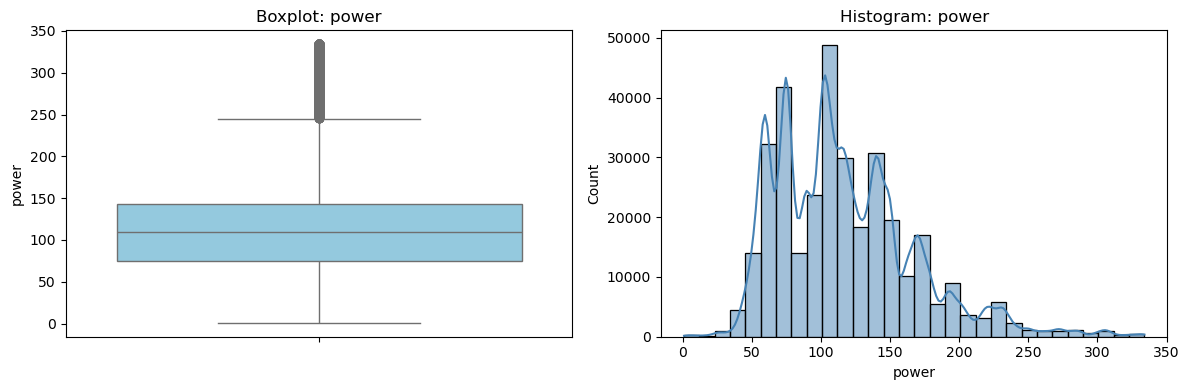

In [21]:
plot_num_feature(data, 'power')

Взгляну и на категориальные переменные

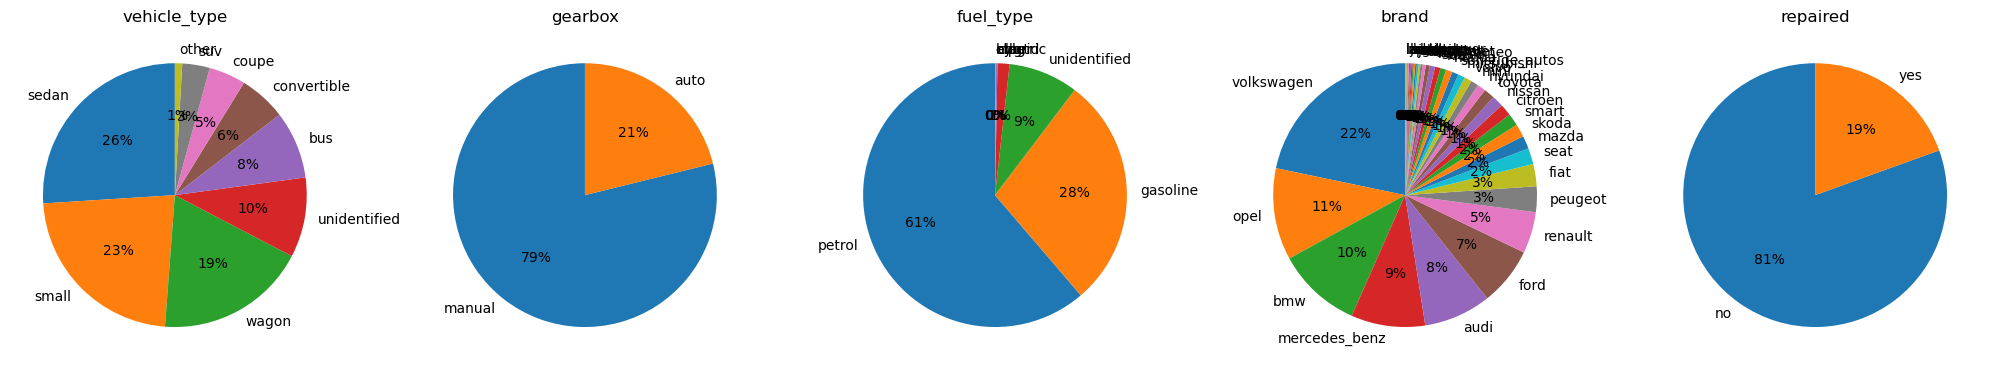

In [22]:
plot_cat_features(data, 'vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired')


<div class="alert alert-block alert-info">
<b>Совет:</b>  Графики не очень читабельны (их размер оставляет желать лучшего), а также отображение факторов с большим кол-вом категорий можно сделать адаптивнее

В основном мы смотрим на меданы или миникуперы, с ручной коробкой передач, которые катаются на бензине. Чаще всего это не чиненые "немцы". Будем знать.

**Вывод по блоку обработки данных:**

Общее качество данных оставляет желать лучшего. Чтобы привести его к удобоваримому виду был проделан ряд операций по предоработке:

1) Удалены неинформативные столбцы
2) Обрезаны данные с нереалистичными значениями лет
3) Заполнены пропуска:
   * 'unidentified' - для разных строковых признаков
   * Случайное заполнение для булевых значений
   * по среднему значению в бренде для записей без указания мощности авто
4) Удалены выбросы
5) Типы данных для временных меток приведены к верным


<div class="alert alert-block alert-success">
<b>Успех:</b> В целом хорошая, детальная предобработка, но можно было еще уделить внимание корреляциями
</div>

<div class="alert alert-block alert-info">
<b>Совет:</b> 

 Советую обратить внимание на библиотеки sweetviz и ydata_profiling помогут в проведении более тщательного EDA анализа. Я использую их в своей работе для первичного осмотра данных, но это можно делать и с помощью ручного вызова функций дефолтных библиотек. Данные библиотеки хороши для максимизации комфорта презентации результатов анализа бизнес-пользователям. 
    
Очень просты в использоовании, на вход кладется датафрейм: ydata_profiling.ProfileReport(df) 
</div>


## Заведение моделей<a name="5"></a>

In [23]:
X = data.drop('price', axis=1)
y = data['price']

cat_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
for col in cat_cols:
    X[col] = X[col].astype('category')


X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.176, random_state=42) 

### Линейная регрессия<a name="6"></a>

In [24]:
num_cols = [c for c in X_train.columns if c not in cat_cols]

ct_ohe = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', Pipeline(steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
], remainder='drop')

ct_oe = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', Pipeline(steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]), cat_cols)
], remainder='drop')

X_train_ohe = ct_ohe.fit_transform(X_train)
X_val_ohe   = ct_ohe.transform(X_val)
X_test_ohe  = ct_ohe.transform(X_test)

X_train_oe = ct_oe.fit_transform(X_train)
X_val_oe   = ct_oe.transform(X_val)
X_test_oe  = ct_oe.transform(X_test)

lr_pipe = Pipeline(steps=[('prep', ct_ohe), ('model', LinearRegression())])

t0 = time.time()
lr_pipe.fit(X_train, y_train)
train_time_lr = time.time() - t0

t0 = time.time()
y_pred_lr = lr_pipe.predict(X_val)
pred_time_lr = time.time() - t0

rmse_lr = np.sqrt(np.mean((y_val - y_pred_lr) ** 2))
print(f'Валидация линейной регрессии RMSE: {rmse_lr:.2f}')
print(f'Время обучения: {train_time_lr:.4f} сек., Время на предсказание: {pred_time_lr:.4f} сек.')

Валидация линейной регрессии RMSE: 2879.90
Время обучения: 0.2998 сек., Время на предсказание: 0.0341 сек.



<div class="alert alert-block alert-danger">

<b>Ошибка:</b>  В чем смысл делать два разных препроцессора? Если они идентичные?) Полагаю, что должна была быть какая-то разница. А теперь к ошибке:
    
    
OHE правильный выбор для линейных моделей. Но для всех других моделей выбор плохой (из-за фактора модели, который порождает много факторов), для заказчика важно время обучения и скорость предсказания, а данные модели могут работать и с другими методами кодировками значительно быстреее, не теряя при этом в качестве.

Я тебе могу предложить, что можно сделать:
    
- Сделать 1 набор данных: 
    - Закодировать для всех моделей методом TargetEncoder, BinaryEncoder - вполне универсальные варианты
    - Закодировать все признаки методом OHE, а модель машины методом OE
    - Заменить использование линейных моделей (так как их рассмотрение не обязательно) и использовать единственный метод кодировки OE.
- Сделать 2 набора данных
    - Закодировать для линейных моделей методом OHE, для остальных OE (или внутренний метод кодирования данных)
    
  
</div>



<div class="

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Дубликат препроцессора удален. Последовал по вашему варианту с 2 кодировками. Теперь должно стать лучше. RMSE LGBM немного снизился
</div>

<div class="alert alert-block alert-success">
    
<b>Успех[2]:</b> 👍 Есть контакт
</div>


### LightGBM<a name="7"></a>

In [25]:
for n in [100, 200, 300, 400, 500]:
    model = LGBMRegressor(n_estimators=n, learning_rate=0.1, random_state=42, verbose=-1)
    start = time.time()
    model.fit(X_train_oe, y_train)
    train_time = time.time() - start
    start = time.time()
    preds = model.predict(X_val_oe)
    pred_time = time.time() - start
    rmse = np.sqrt(np.mean((y_val - preds)**2))
    print(f"LGBM (n={n}) -> RMSE: {rmse:.2f}, Время обучения: {train_time:.2f}с, Время предсказания: {pred_time:.2f}с")


LGBM (n=100) -> RMSE: 1773.12, Время обучения: 0.41с, Время предсказания: 0.04с
LGBM (n=200) -> RMSE: 1721.45, Время обучения: 0.70с, Время предсказания: 0.08с
LGBM (n=300) -> RMSE: 1692.40, Время обучения: 0.93с, Время предсказания: 0.10с
LGBM (n=400) -> RMSE: 1671.71, Время обучения: 1.07с, Время предсказания: 0.13с
LGBM (n=500) -> RMSE: 1658.86, Время обучения: 1.30с, Время предсказания: 0.16с


### XGBoost<a name="8"></a>

In [26]:
for n in [100, 200, 300, 400, 500]:
    model = XGBRegressor(n_estimators=n, max_depth=6, learning_rate=0.1, tree_method='hist',
                         eval_metric='rmse', random_state=42)
    start = time.time()
    model.fit(X_train_oe, y_train)
    train_time = time.time() - start
    start = time.time()
    preds = model.predict(X_val_oe)
    pred_time = time.time() - start
    rmse = np.sqrt(np.mean((y_val - preds)**2))
    print(f"XGBoost (n={n}) -> RMSE: {rmse:.2f}, Время обучения: {train_time:.2f}с, Время предсказания: {pred_time:.2f}с")


XGBoost (n=100) -> RMSE: 1758.87, Время обучения: 0.29с, Время предсказания: 0.02с
XGBoost (n=200) -> RMSE: 1705.21, Время обучения: 0.55с, Время предсказания: 0.03с
XGBoost (n=300) -> RMSE: 1681.01, Время обучения: 0.75с, Время предсказания: 0.04с
XGBoost (n=400) -> RMSE: 1665.97, Время обучения: 1.00с, Время предсказания: 0.04с
XGBoost (n=500) -> RMSE: 1653.65, Время обучения: 1.21с, Время предсказания: 0.06с


### CatBoost<a name="9"></a>

In [27]:
cat_features_indices = [X_train.columns.get_loc(col) for col in cat_cols]

for n in [100, 200, 300, 400, 500]:
    model = CatBoostRegressor(iterations=n, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
    start = time.time()
    model.fit(X_train, y_train, cat_features=cat_features_indices)
    train_time = time.time() - start
    start = time.time()
    preds = model.predict(X_val)
    pred_time = time.time() - start
    rmse = np.sqrt(np.mean((y_val - preds)**2))
    print(f"CatBoost (trees={n}) -> RMSE: {rmse:.2f}, Время обучения: {train_time:.2f}с, Время предсказания: {pred_time:.2f}с")


CatBoost (trees=100) -> RMSE: 1844.98, Время обучения: 1.36с, Время предсказания: 0.00с
CatBoost (trees=200) -> RMSE: 1765.52, Время обучения: 5.11с, Время предсказания: 0.01с
CatBoost (trees=300) -> RMSE: 1734.60, Время обучения: 7.64с, Время предсказания: 0.01с
CatBoost (trees=400) -> RMSE: 1715.40, Время обучения: 10.57с, Время предсказания: 0.02с
CatBoost (trees=500) -> RMSE: 1703.24, Время обучения: 13.45с, Время предсказания: 0.03с



<div class="alert alert-block alert-success">
<b>Успех:</b> Лайк за внутренний метод кодировки данных
</div>




Наилучшая по соотношению параметров, которые важны для заказчика, на мой взгляд - это LightGBM, ее и проверю на тестовом наборе данных.

**Общий подвывод:**
1) Хуже всего проявила себя линейная регрессия. Она не очень подходит для таких задач.
2) Средне показала себя CatBoost - она слишком долго обучается, при хороших значениях скорости предсказания
3) Лучшие - XGBoost и LightGBM, но последняя - лучше масштабируется и более гибко настраивается, поэтому беру ее как базовую


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично проделан шаг
    
- Радует количество рассмотренных моделей.   
- Валидационная выборка успешно использована
- Все метрики интересующие заказчика корректно вычислены и проанализированы. 
- Выбор лучшей модели обоснован. 
</div>






<div class="alert alert-block alert-info">
<b>Совет:</b> Неплохо было бы собрать результаты в информативную таблцу


</div>


In [28]:
X_trainval_oe = ct_oe.fit_transform(X_trainval)

lgbm = LGBMRegressor(n_estimators=500, learning_rate=0.1, random_state=42)

t0 = time.time()
lgbm.fit(X_trainval_oe, y_trainval)
train_time = time.time() - t0

t0 = time.time()
y_pred_test = lgbm.predict(X_test_oe)
pred_time = time.time() - t0

rmse_test = np.sqrt(np.mean((y_test - y_pred_test) ** 2))
print(f"LightGBM тест RMSE: {rmse_test:.2f}")
print(f"Время обучения: {train_time:.2f} сек")
print(f"Время предсказания: {pred_time:.4f} сек")


LightGBM тест RMSE: 1649.77
Время обучения: 1.66 сек
Время предсказания: 0.1661 сек




<div class="alert alert-block alert-success">
<b>Успех:</b> На тестовой выборке получено хорошее качество!
</div>


## Вывод<a name="10"></a>

В разделе *«Анализ моделей»* были решены следующие задачи:

* составлена сравнительная таблица метрик для различных моделей;
* проведён анализ времени обучения, скорости предсказания и качества результатов;
* на основе критериев заказчика определена оптимальная модель и проверено её качество на тестовой выборке.

По итогам анализа установлено:
модель градиентного бустинга **LightGBM** на тестовой выборке показала RMSE = 1649.77. Для всех рассмотренных моделей значение метрики RMSE оказалось ниже 2500, кроме самой неудачной - линейной регрессии, что соответствует исходным требованиям проекта.



<div class="alert alert-block alert-info">
<b>Совет:</b> 

Также если говорить, что можно ещё улучшить в подобных проектах, то я бы выделил такие моменты:<br>
    
1) Для понимания, а какие в итоге факторы важны при моделировании, можно выводить их важность, использую feature_importances_, ну и график заодно. Это будет смотреться очнь здорово: результативная метрика и график важности факторов)))
    
2) У нас разный возраст машин. Есть гипотеза, что для разных возрастов - своё ценообразование. Поэтому, можно попробовать ввести фактор "тип возраста" (ретро, супер-ретро, старая, новая... надо подумать..)..<br>

3) У LGBM тоже есть внутренний метод кодировки данных, который хорошо было бы попробовать
</div>
